In [78]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2 as cv
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from PIL import Image
import seaborn as sns


#as explain in the dummy code, this definition extracts all of the subfile directorie
#and the images inside of them. It stops when there are no more subdirectories inside a file

def ExtractFiles(directory):
    #lists all of the subfiles in the directory 
    images = []
    file_list = os.listdir(directory)
    #lets go through all the images in the subfiles and save their paths.
    for file in file_list: 
        path = os.path.join(directory,file)
        #lets check if there are subfiles which we need to get more paths from. 
        #If there are, lets go through all the paths inside of these files and add them to the list them.
        if os.path.isdir(path):
            images = images + ExtractFiles(path)
        else:
            images.append(path)
    
    return images

#SOURCE: https://stackoverflow.com/questions/64115145/keras-style-transfer-remove-zero-center-by-mean-pixel
#used to print images in the right color channels later on 
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x


#lets apply this to our directory. 
all_image_paths = ExtractFiles("E:\For Training")
#print(all_image_paths) #Uncomment to check if all file paths are correct. 

In [79]:
#initate our lists for pre processing. 

#will store all image matrices to be turned into an array 
data = []

#will store all the labels for each image. 
labels = []

for image1 in all_image_paths:
    #splits into each image and their label inside label folders. Then we remove the
    #whole path to get the "absolute labels"
    #we need to get the tail of the directoy for labels
    label = os.path.split(os.path.split(image1)[0])[1]
    labels.append(label)
    #print(label) #uncomment to check all labels 


for image_path in all_image_paths:
    model = VGG16(weights='imagenet', include_top=False)
    img_path = image_path
    #40 to 40 best 140 to 140 best
    img = image.load_img(img_path, target_size=(140, 140, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose = 0)
    data.append(x)

In [80]:
#now we need to turn our data into an array that KNN and Label Encoder can understand, 
#right now it is a list. 
X = np.array(data)
y = np.array(labels)

#print(X.shape) #uncomment to see data shape. 

X = X.reshape(X.shape[0],-1)

#print(X.shape) #uncomment to see data shape. 



#lets encode our labels 
coder = LabelEncoder()
y = coder.fit_transform(y)

#split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
#Split rest into 10% testing and 10% validation 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=20) 

#fit the model
model = KNeighborsClassifier(n_neighbors = 2)
model.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(model.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test,y_test)))
print("Accuracy on validation set: {:.3f}".format(model.score(X_val,y_val)))

Accuracy on training set: 0.754
Accuracy on test set: 0.432
Accuracy on validation set: 0.535


In [81]:
#Grid Search
k_range = list(range(2, 11))
param_grid = dict(n_neighbors=k_range)
  
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy', return_train_score=False, verbose=1, n_jobs = -1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.score(X_test, y_test))
print(grid_search.score(X_val, y_val))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   38.2s finished


{'n_neighbors': 2}
0.4318181818181818
0.5348837209302325


In [90]:
joblib.dump(model, "model_v3.pkl") 

model2 = joblib.load("model_v3.pkl")

predicted_label = model2.predict(X_train)

print(classification_report(y_train, predicted_label))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        35
           1       0.70      1.00      0.82        32
           2       0.60      0.79      0.68        42
           3       1.00      0.86      0.93        37
           4       0.63      0.91      0.75        44
           5       0.71      0.60      0.65        40
           6       0.91      0.77      0.83        39
           7       0.92      0.59      0.72        39
           8       1.00      0.30      0.46        37

    accuracy                           0.75       345
   macro avg       0.80      0.76      0.74       345
weighted avg       0.80      0.75      0.74       345



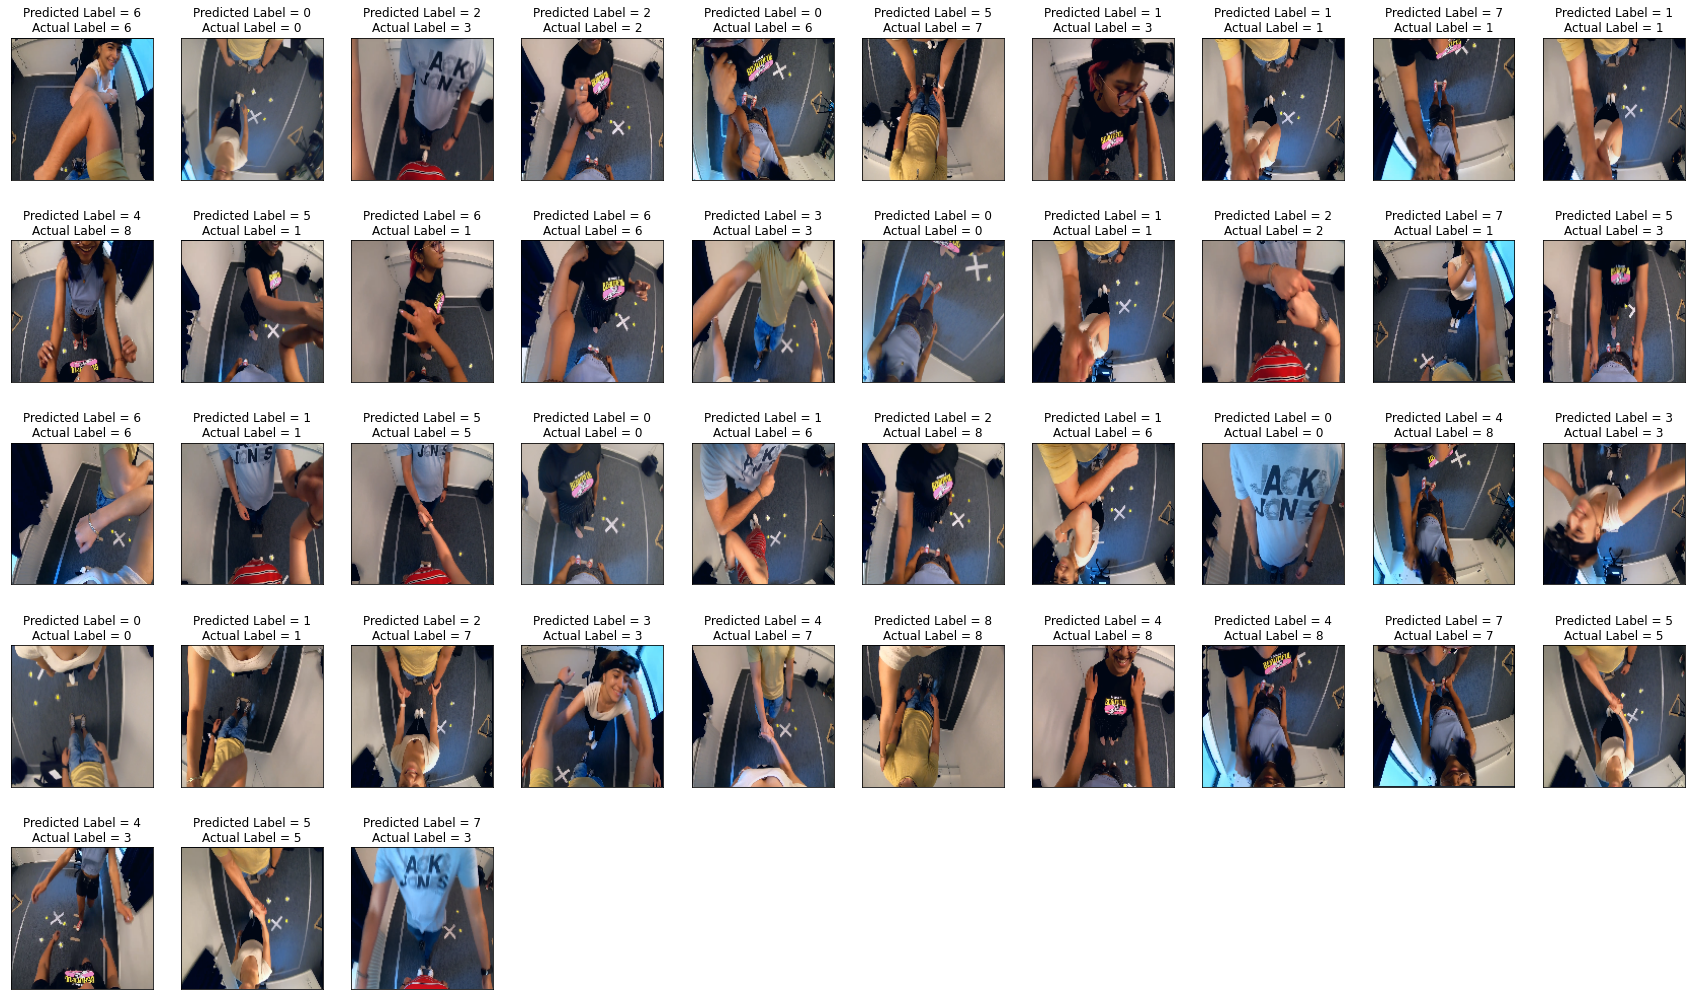

In [86]:
fig, axes = plt.subplots(5, 10, figsize=(30, 18),
subplot_kw={'xticks':(), 'yticks': ()})
for ax, img, label, rlab in zip(axes.ravel(), X_val, predicted_label, y_val):
    img = np.reshape(img, (140, 140, 3))
    deprocess_img(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    image_test = image.array_to_img(img)
    ax.imshow(image_test)
    buf = "Predicted Label = %d" % label + "\n" + "Actual Label = %d" % int(rlab)
    ax.set_title(buf) 

fig.delaxes(axes[4][3])
fig.delaxes(axes[4][4])
fig.delaxes(axes[4][5])
fig.delaxes(axes[4][6])
fig.delaxes(axes[4][7])
fig.delaxes(axes[4][8])
fig.delaxes(axes[4][9])
    
#0  Control   
#1. High Five
#2. Fist Bump
#3. Hug
#4. Arm Touch
#5. Handshake
#6. Elbow Bump
#7. Hold Hands
#8. Shoulder tap

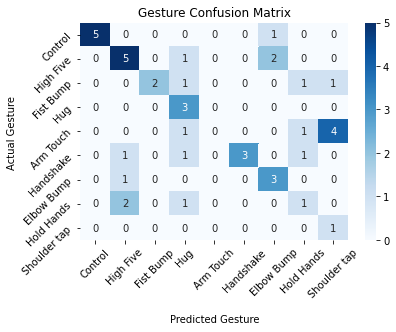

In [83]:
#confusion matrix #https://seaborn.pydata.org/generated/seaborn.heatmap.html
cf_matrix = confusion_matrix(predicted_label, y_val)

ax2 = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax2.set_title('Gesture Confusion Matrix');
ax2.set_xlabel('\nPredicted Gesture')
ax2.set_ylabel('Actual Gesture ');
## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Control', 'High Five', 'Fist Bump', 'Hug', 'Arm Touch', 'Handshake', 'Elbow Bump', 'Hold Hands', 'Shoulder tap'], rotation=45)
ax2.yaxis.set_ticklabels(['Control', 'High Five', 'Fist Bump', 'Hug', 'Arm Touch', 'Handshake', 'Elbow Bump', 'Hold Hands', 'Shoulder tap'], rotation=45)
## Display the visualization of the Confusion Matrix.
plt.show()

In [84]:
#Sources 

#https://medium.com/swlh/image-classification-with-k-nearest-neighbours-51b3a289280

#https://www.tensorflow.org/tutorials/images/classification

#https://pyimagesearch.com/2021/04/17/your-first-image-classifier-using-k-nn-to-classify-images/#:~:text=The%20k%2DNearest%20Neighbor%20classifier,t%20actually%20%E2%80%9Clearn%E2%80%9D%20anything.

#https://mylearningsinaiml.wordpress.com/deep-learning/dl4cv/first-image-classifier/

#https://stackoverflow.com/questions/72103258/how-iterate-through-a-folder-by-subfolder-in-python